In [101]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score

In [102]:
energy = pd.read_csv("datasets/energy_dataset.csv")

In [103]:
energy.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


#### Time Feature Extraction

In [104]:
energy["time"] = pd.to_datetime(energy["time"], utc=True)

energy["day"] = energy["time"].dt.day
energy["month"] = energy["time"].dt.month
energy["hour"] = energy["time"].dt.hour
energy["day_of_week"] = energy["time"].dt.day_of_week

def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3,4,5]:
        return "Spring"
    elif month in [6,7,8]:
        return "Fall"
    else:
        return "Winter"
    
energy["season"] = energy["month"].apply(get_season)   


In [107]:
energy.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual,day,month,hour,day_of_week,season
0,2014-12-31 23:00:00+00:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,6436.0,26118.0,25385.0,50.10,65.41,31,12,23,2,Winter
1,2015-01-01 00:00:00+00:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,5856.0,24934.0,24382.0,48.10,64.92,1,1,0,3,Winter
2,2015-01-01 01:00:00+00:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,5454.0,23515.0,22734.0,47.33,64.48,1,1,1,3,Winter
3,2015-01-01 02:00:00+00:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,5151.0,22642.0,21286.0,42.27,59.32,1,1,2,3,Winter
4,2015-01-01 03:00:00+00:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,4861.0,21785.0,20264.0,38.41,56.04,1,1,3,3,Winter


In [108]:
energy.isna().sum()

time                                               0
generation biomass                                19
generation fossil brown coal/lignite              18
generation fossil coal-derived gas                18
generation fossil gas                             18
generation fossil hard coal                       18
generation fossil oil                             19
generation fossil oil shale                       18
generation fossil peat                            18
generation geothermal                             18
generation hydro pumped storage aggregated     35064
generation hydro pumped storage consumption       19
generation hydro run-of-river and poundage        19
generation hydro water reservoir                  18
generation marine                                 19
generation nuclear                                17
generation other                                  18
generation other renewable                        18
generation solar                              

#### Removing Missing Values

In [109]:
for column in energy.columns:
    if energy[column].isnull().sum() / len(energy) < 0.05 and energy[column].isnull().sum() / len(energy) > 0:
        energy[column].fillna(energy[column].mean(), inplace=True)
        
energy.dropna(axis=1, how='all', inplace=True)

C:\Users\aakas\AppData\Local\Temp\ipykernel_20384\3254980725.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  energy[column].fillna(energy[column].mean(), inplace=True)


In [111]:
energy.isna().sum()

time                                           0
generation biomass                             0
generation fossil brown coal/lignite           0
generation fossil coal-derived gas             0
generation fossil gas                          0
generation fossil hard coal                    0
generation fossil oil                          0
generation fossil oil shale                    0
generation fossil peat                         0
generation geothermal                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation marine                              0
generation nuclear                             0
generation other                               0
generation other renewable                     0
generation solar                               0
generation waste                               0
generation wind offshore                       0
generation wind onsh

#### Lag Features

In [113]:
energy.set_index("time", inplace=True)

for lag in range(1,8):
    energy[f"total_load_actual_lag{lag}"] = energy["total load actual"].shift(lag)

energy_daily = energy.resample('D').sum()

for lag in range(1, 8):
    energy_daily[f"total_load_actual_lag{lag}"] = energy_daily["total load actual"].shift(lag)
 
energy_weekly = energy.resample("W").sum()

for lag in range(1, 8):
    energy_weekly[f'total_load_actual_lag{lag}'] = energy_weekly['total load actual'].shift(lag)
    
energy["hour"] = energy.index.hour
energy["day"] = energy.index.day
energy["month"] = energy.index.month

In [147]:
features = [
    'generation solar', 'generation wind onshore', 'forecast solar day ahead', 
    'price day ahead', 'hour', 'day', 'month'
] + [f'total_load_actual_lag{lag}' for lag in range(1, 8)]
target = 'total load actual'

In [149]:
descriptive_stats = energy[features].describe()
descriptive_stats

,generation solar,generation wind onshore,forecast solar day ahead,price day ahead,hour,day,month,total_load_actual_lag1,total_load_actual_lag2,total_load_actual_lag3,total_load_actual_lag4,total_load_actual_lag5,total_load_actual_lag6,total_load_actual_lag7
count,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35063.000000,35062.000000,35061.000000,35060.000000,35059.000000,35058.000000,35057.000000
mean,1432.665925,5464.479769,1439.066735,49.874341,11.500000,15.729637,6.522930,28697.060886,28697.143484,28697.161343,28697.131741,28697.075953,28697.050426,28697.106308
std,1679.688577,3212.866588,1677.703355,14.618900,6.922285,8.800218,3.448752,4572.647813,4572.686864,4572.750853,4572.812709,4572.865995,4572.928717,4572.981969
min,0.000000,0.000000,0.000000,2.060000,0.000000,1.000000,1.000000,18041.000000,18041.000000,18041.000000,18041.000000,18041.000000,18041.000000,18041.000000
25%,71.000000,2933.750000,69.000000,41.490000,5.750000,8.000000,4.000000,24810.000000,24810.000000,24810.000000,24810.000000,24810.000000,24810.000000,24810.000000
50%,616.000000,4850.500000,576.000000,50.520000,11.500000,16.000000,7.000000,28894.000000,28894.500000,28895.000000,28894.500000,28894.000000,28894.000000,28894.000000
75%,2575.250000,7397.000000,2636.000000,60.530000,17.250000,23.000000,10.000000,32186.500000,32186.750000,32187.000000,32187.000000,32187.000000,32187.000000,32187.000000
max,5792.000000,17436.000000,5836.000000,101.990000,23.000000,31.000000,12.000000,41015.000000,41015.000000,41015.000000,41015.000000,41015.000000,41015.000000,41015.000000


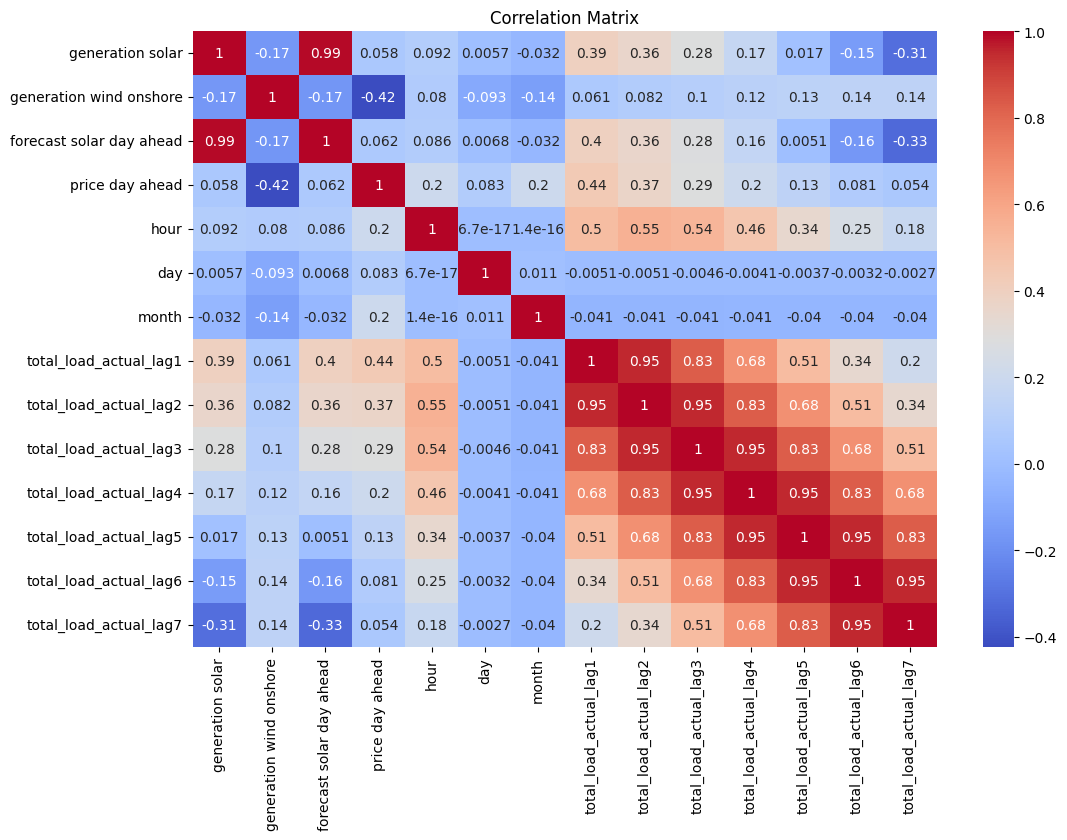

In [119]:
plt.figure(figsize=(12, 8))
correlation_matrix = energy[features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [120]:
X = energy[features]
y = energy[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Random Forest

In [121]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

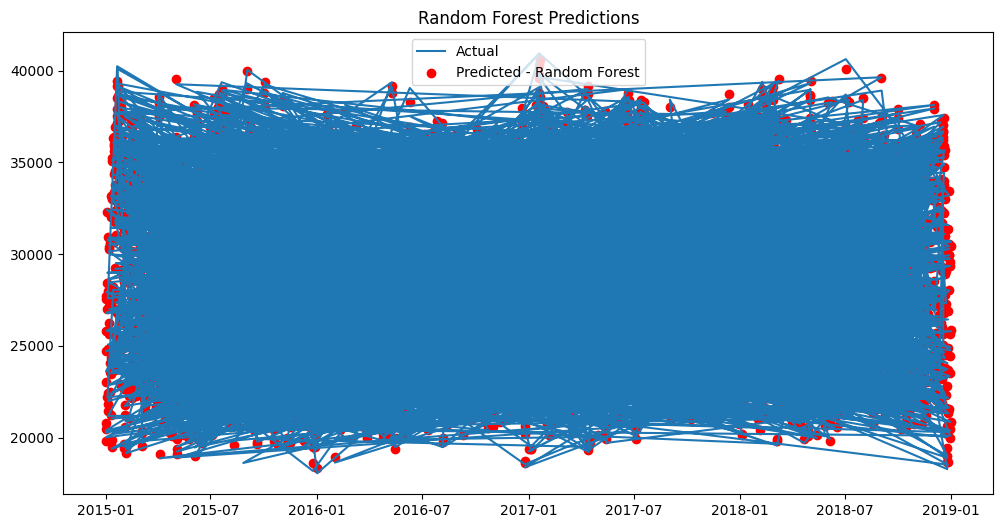

In [134]:
plt.figure(figsize=(12, 6))

plt.plot(y_test.index, y_test, label='Actual')

plt.scatter(y_test.index, y_pred_rf, label='Predicted - Random Forest',color='red')

plt.legend()
plt.title('Random Forest Predictions')
plt.show()

#### XGBoost

In [123]:
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror')
xgb_model.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test)

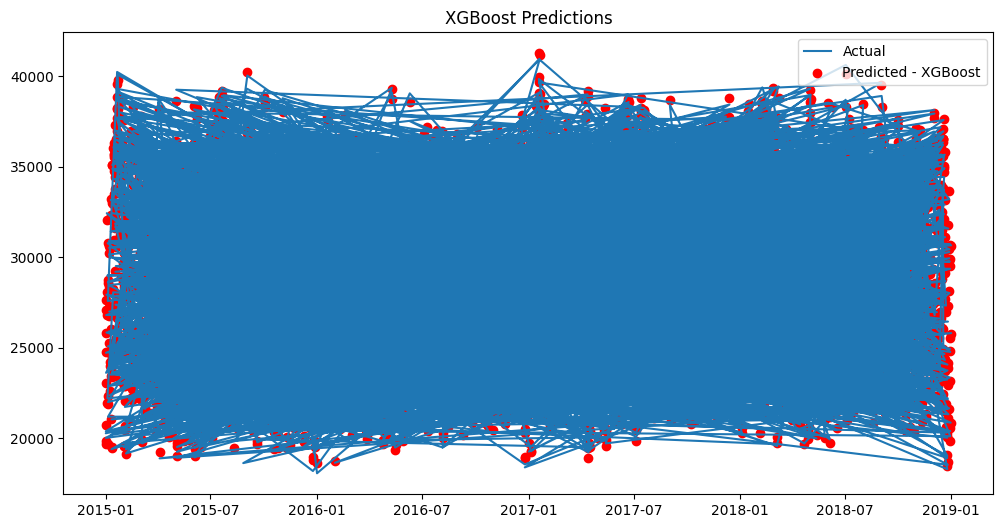

In [124]:
plt.figure(figsize=(12, 6))

plt.plot(y_test.index, y_test, label='Actual')

plt.scatter(y_test.index, y_pred_xgb, label='Predicted - XGBoost',color='red')

plt.legend()
plt.title('XGBoost Predictions')
plt.show()

#### ARIMA

In [125]:
arima_model = ARIMA(y_train, order=(5, 1, 0))
arima_model_fit = arima_model.fit()


y_pred_arima = arima_model_fit.forecast(steps=len(y_test))


c:\Users\aakas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\aakas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\aakas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\aakas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not mo

c:\Users\aakas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\aakas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\aakas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\aakas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not mo

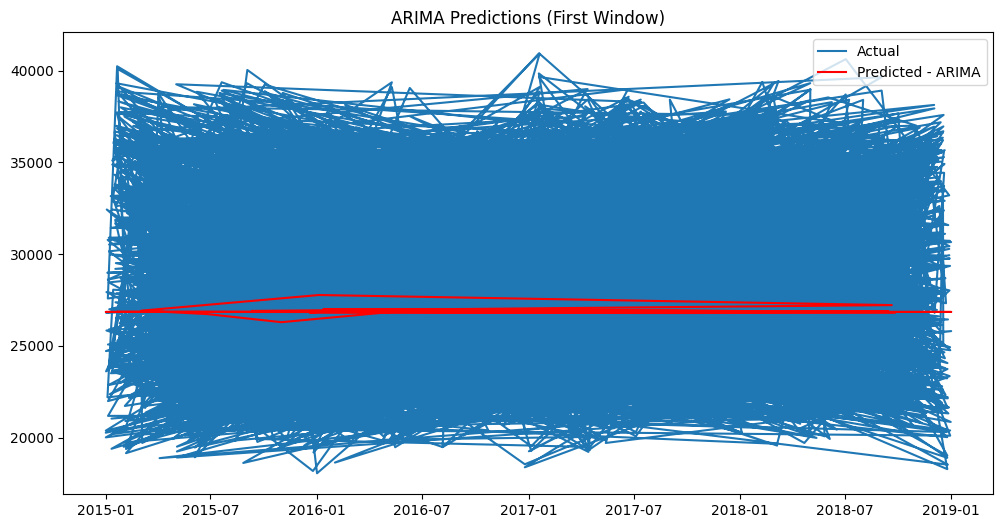

In [126]:
# Perform rolling window cross-validation for ARIMA
n_windows = 3  # Adjust as needed
window_size = len(y_train) // n_windows

rmse_arima = []
mae_arima = []
mape_arima = []

for i in range(n_windows):
    train_data = y_train[:window_size*(i+1)]
    test_data = y_test[window_size*i:window_size*(i+1)]
    
    if len(test_data) == 0:
        break
    
    # Set the frequency for the train and test data indices
    train_data.index.freq = pd.infer_freq(train_data.index)
    test_data.index.freq = pd.infer_freq(test_data.index)
    
    model = ARIMA(train_data, order=(5, 1, 0))
    arima_fit = model.fit()
    forecasts = arima_fit.forecast(steps=len(test_data))
    
    rmse = np.sqrt(mean_squared_error(test_data, forecasts))
    mae = mean_absolute_error(test_data, forecasts)
    mape = np.mean(np.abs((test_data - forecasts) / test_data)) * 100
    
    rmse_arima.append(rmse)
    mae_arima.append(mae)
    mape_arima.append(mape)
    
plt.figure(figsize=(12, 6))
plt.plot(y_test.index[:window_size], y_test[:window_size], label='Actual')
plt.plot(y_test.index[:window_size], forecasts, label='Predicted - ARIMA', color='red')
plt.legend()
plt.title('ARIMA Predictions (First Window)')
plt.show()

#### Cross Validation

In [127]:
cv = 3

# Random Forest
cv_rmse_rf = np.sqrt(-cross_val_score(rf_model, X, y, scoring='neg_mean_squared_error', cv=cv))
cv_mae_rf = -cross_val_score(rf_model, X, y, scoring='neg_mean_absolute_error', cv=cv)
cv_mape_rf = -cross_val_score(rf_model, X, y, scoring='neg_mean_absolute_percentage_error', cv=cv)

print(f'Random Forest - CV RMSE: {cv_rmse_rf.mean()}, CV MAE: {cv_mae_rf.mean()}, CV MAPE: {cv_mape_rf.mean()}')

# XGBoost
cv_rmse_xgb = np.sqrt(-cross_val_score(xgb_model, X, y, scoring='neg_mean_squared_error', cv=cv))
cv_mae_xgb = -cross_val_score(xgb_model, X, y, scoring='neg_mean_absolute_error', cv=cv)
cv_mape_xgb = -cross_val_score(xgb_model, X, y, scoring='neg_mean_absolute_percentage_error', cv=cv)

print(f'XGBoost - CV RMSE: {cv_rmse_xgb.mean()}, CV MAE: {cv_mae_xgb.mean()}, CV MAPE: {cv_mape_xgb.mean()}')

#ARIMA
mean_rmse_arima = np.mean(rmse_arima)
mean_mae_arima = np.mean(mae_arima)
mean_mape_arima = np.mean(mape_arima)

print(f'ARIMA - Mean RMSE: {mean_rmse_arima}, Mean MAE: {mean_mae_arima}, Mean MAPE: {mean_mape_arima}')

Random Forest - CV RMSE: 540.0992438503836, CV MAE: 310.78503375628105, CV MAPE: 0.011034920746302149


#### Metrics

In [130]:
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, mape, r2

# Calculate metrics for Random Forest
rmse_rf, mae_rf, mape_rf, r2_rf = calculate_metrics(y_test, y_pred_rf)
print(f'Random Forest - RMSE: {rmse_rf}, MAE: {mae_rf}, MAPE: {mape_rf}, R2 Score: {r2_rf}')

# Calculate metrics for XGBoost
rmse_xgb, mae_xgb, mape_xgb, r2_xgb = calculate_metrics(y_test, y_pred_xgb)
print(f'XGBoost - RMSE: {rmse_xgb}, MAE: {mae_xgb}, MAPE: {mape_xgb}, R2 Score: {r2_xgb}')

# Calculate metrics for ARIMA
rmse_arima, mae_arima, mape_arima, r2_arima = calculate_metrics(y_test, y_pred_arima)
print(f'ARIMA - RMSE: {rmse_arima}, MAE: {mae_arima}, MAPE: {mape_arima}, R2 Score: {r2_arima}')

Random Forest - RMSE: 501.92987177047246, MAE: 277.55894055251406, MAPE: 0.009845057729956662, R2 Score: 0.9879123941192581
XGBoost - RMSE: 513.7154499027793, MAE: 308.8698110405096, MAPE: 0.010976374067767981, R2 Score: 0.9873380830736369
ARIMA - RMSE: 7045.745043734059, MAE: 5756.379069359932, MAPE: 0.1841358208263243, R2 Score: -1.3818151478559613


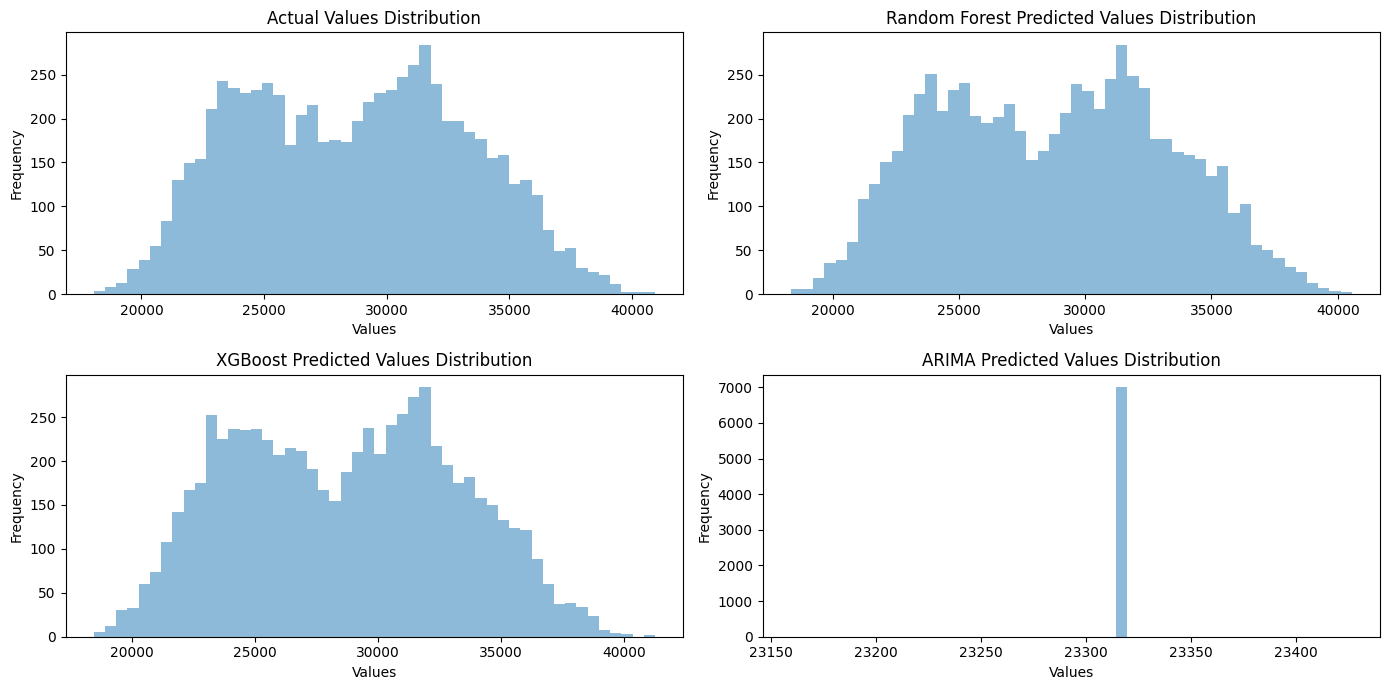

In [155]:
plt.figure(figsize=(14, 7))

plt.subplot(2, 2, 1)
plt.hist(y_test, bins=50, alpha=0.5, label='Actual')
plt.title('Actual Values Distribution')
plt.xlabel('Values')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(y_pred_rf, bins=50, alpha=0.5, label='Predicted - Random Forest')
plt.title('Random Forest Predicted Values Distribution')
plt.xlabel('Values')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
plt.hist(y_pred_xgb, bins=50, alpha=0.5, label='Predicted - XGBoost')
plt.title('XGBoost Predicted Values Distribution')
plt.xlabel('Values')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
plt.hist(y_pred_arima, bins=50, alpha=0.5, label='Predicted - ARIMA')
plt.title('ARIMA Predicted Values Distribution')
plt.xlabel('Values')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


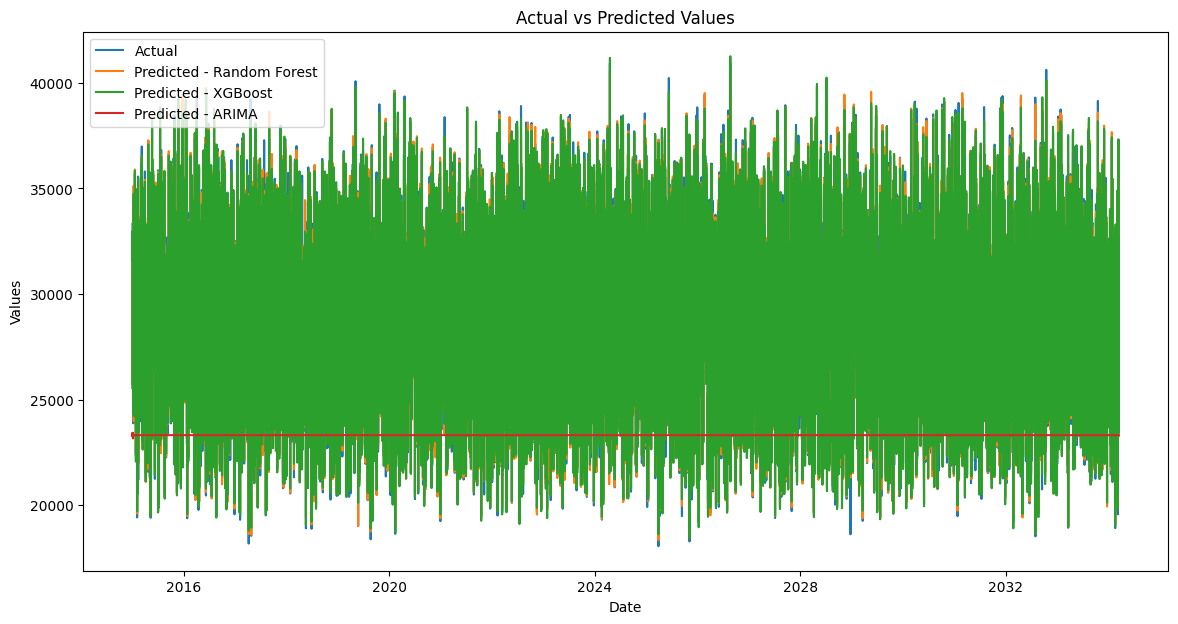

In [140]:
date_index = pd.date_range(start='2015-01-01', periods=len(y_test), freq='D')

plt.figure(figsize=(14, 7))
plt.plot(date_index, y_test, label='Actual')
plt.plot(date_index, y_pred_rf, label='Predicted - Random Forest')
plt.plot(date_index, y_pred_xgb, label='Predicted - XGBoost')
plt.plot(date_index, y_pred_arima, label='Predicted - ARIMA')
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()